In [1]:
import numpy as np
from scipy.linalg import sqrtm
from PIL import Image
import matplotlib.pyplot as plt
import cv2, itertools, copy
from tqdm import tqdm
_EPSILON = 1e-9


# will get input image and apply median filter on it to 
# do the pre-filtering step (in order to decouplate W and y)
def pre_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

# will get input image and p and outputs spatially uniform sample 
# and list of image's pixels after discarding samples
def spatial_uniform_sampling(image, p, x_offset=0, y_offset=0):
    # Get the dimensions of the input image
    height, width = image.shape
    
    # Compute the number of samples to take in each dimension
    num_samples = int(np.sqrt(p))
    
    # Compute the stride length for sampling in each dimension
    stride = int(np.floor(height / num_samples))
    
    # Compute the starting coordinates for sampling in each dimension
    y_start = int(np.floor((height - stride * num_samples) / 2))+y_offset
    x_start = int(np.floor((width - stride * num_samples) / 2))+x_offset

    # Compute discarded image size
    complement = np.copy(image).astype(np.int16)
    
    # Create an empty array to hold the sample sub-image
    sample = np.zeros((num_samples, num_samples))

    # store indices
    sample_indices = []
    
    # Loop over the sample sub-image and fill it with the corresponding pixels from the input image
    for i in range(num_samples):
        for j in range(num_samples):
            y = y_start + i * stride
            x = x_start + j * stride
            sample[i, j] = image[y, x]
            sample_indices += [[y,x]]
            complement[x, y]= -1
    
    return sample, np.array(sample_indices), complement[complement >= 0].astype(np.uint8),np.argwhere(complement >= 0)


def uniform_sampling(image, p):
    height, width = image.shape
    indices = np.random.choice(height*width, size=p, replace=False)

    # Convert the 1D indices to 2D coordinates
    y, x = np.unravel_index(indices, (height, width))

    # Extract the corresponding points from the image
    samples = image[y, x]
    samples_ind = np.hstack((y.reshape(-1,1),x.reshape(-1,1)))

    complement = np.copy(image).astype(np.int16)
    complement[samples_ind[:,0],samples_ind[:,1]] = -1

    complement_ind = np.argwhere(complement != -1)
    complement = complement[complement != -1]

    return samples, samples_ind, complement.astype(np.uint8), complement_ind

# will get two array and returns the grid of them
def grid_of(I1, I2, pair_shape):
    return np.fromiter(itertools.product(I1, I2), dtype=np.dtype((int, pair_shape))).reshape(I1.shape[0],I2.shape[0],-1)

# Classical Gaussian similarity measure between the pixel
# x1,x2 are two vectors
def Exponential_Kernel(x, σ=2500):
    delta = np.einsum('ijkl,k->ijl',x.reshape(x.shape[0],x.shape[1],2,-1),np.array([-1,1]))
    n_sqr = np.einsum('ijk,ijk->ij',delta, delta)
    f_rsl = np.exp(-n_sqr/σ)
    return f_rsl

# 0,1 Linear Kernel
def Linear_kernel(x, σ=255):
    delta = np.einsum('ijkl,k->ijl',x.reshape(x.shape[0],x.shape[1],2,-1),np.array([-1,1]))
    f_rsl = 1.-np.abs(delta/σ)
    return f_rsl

# Guassian Kernel Similarity Measure
def G_Similarity(X1, X2=None, σ1=2500):
    X2 = X1 if X2 is None else X2
    return Exponential_Kernel(grid_of(X1,X2,pair_shape=(2,2)), σ=σ1)

# Bilateral Kernal Similarity measure
def B_Similarity(X1,Y1,X2=None,Y2=None, σ1=2500, σ2=500):
    X2 = X1 if X2 is None else X2
    Y2 = Y1 if Y2 is None else Y2
    spatial = Exponential_Kernel(grid_of(X1,X2,pair_shape=(2,2)), σ=σ1)
    intensity = Exponential_Kernel(grid_of(Y1,Y2,pair_shape=(2)), σ=σ2)
    return spatial*intensity

# 0,1 intensity similarity
def N_Similarity(Y1, Y2=None, σ1=255, is_linear=True):
    Y2 = Y1 if Y2 is None else Y2
    if is_linear: intensity = Linear_kernel(grid_of(Y1,Y2,pair_shape=(2)), σ=σ1)
    else : intensity = Exponential_Kernel(grid_of(Y1,Y2,pair_shape=(2)), σ=σ1)
    return intensity.squeeze(-1)


# compute global filter given the image, number of spatial uniform
# samples and number of leading eigen vectors
def Spectral_Approximation_of_the_Filter_W(image, _iter, p, x_offset, y_offset, similarity_measure, σ1=2500, σ2=500, is_linear=True):

    # specify given image
    # image = np.random.randint(0,10,size=(10,10))

    # Specify the iteration parameter
    # _iter = 4

    # Load the input image
    # image = np.random.randint(1,40,size=(n,n))

    # Specify the size of the sample sub-image
    # p = 25
    n = image.shape[0] * image.shape[1]

    # Get the sample sub-image using spatially uniform sampling
    # sample, sample_ind, complement, complement_ind = spatial_uniform_sampling(image, p, x_offset, y_offset)
    sample, sample_ind, complement, complement_ind = spatial_uniform_sampling(image, p)

    # list of sampled pixels
    sample = sample.reshape(-1)

    if similarity_measure.__name__=='G_Similarity':
        # similarity sub kernel
        K_A = similarity_measure(sample_ind, σ1=σ1)

        # similarity rectangular sub kernel
        K_AB = similarity_measure(sample_ind, complement_ind, σ1=σ1)

    elif similarity_measure.__name__=='B_Similarity':
        # similarity sub kernel
        K_A = similarity_measure(sample_ind, sample, σ1=σ1, σ2=σ2)

        # similarity rectangular sub kernel
        K_AB = similarity_measure(sample_ind, sample, complement_ind, complement, σ1=σ1, σ2=σ2)
    
    elif similarity_measure.__name__=='N_Similarity':
        # similarity sub kernel
        K_A = similarity_measure(sample, σ1=σ1, is_linear=is_linear)

        # similarity rectangular sub kernel
        K_AB = similarity_measure(sample, complement, σ1=σ1, is_linear=is_linear)

    # Nystrom Approximation
    # 1-
    π_A, Φ_A, = np.linalg.eig(K_A)
    # 2-
    Φ_tilde = np.vstack((Φ_A,K_AB.T@Φ_A@np.diag(1./(π_A+_EPSILON))))

    # Sinkhorn
    # 3-
    r,π_A = np.ones((n,1)),π_A.reshape(-1,1)
    # 4-
    for _ in range(_iter):
        c = 1/(Φ_tilde@(π_A*(Φ_tilde.T@r)))
        r = 1/(Φ_tilde@(π_A*(Φ_tilde.T@c)))
    # 5-
    W_A_AB = []
    for i in range(0,p):
        W_A_AB += [r[i]*(π_A.T*Φ_tilde[i,:])@(np.tile(c, [1,p])*Φ_tilde).T]
    W_A_AB = np.squeeze(W_A_AB, axis=1)
    # 6-
    W_A = W_A_AB[:,0:p]
    # 7-
    W_AB = W_A_AB[:,p:n]

    # Orthogonalization
    # 8-
    W_A_sqrt = sqrtm(W_A)
    # 9-
    Q = W_A + np.linalg.inv(W_A_sqrt)@W_AB@W_AB.T@np.linalg.inv(W_A_sqrt)
    # 10-
    s_Q, V_Q, = np.linalg.eig(Q)
    # 11-
    V_tilde = np.vstack((W_A,W_AB.T))@np.linalg.inv(W_A_sqrt)@V_Q@np.diag(1./np.sqrt(s_Q))
    # 12-
    s_tilde = s_Q

    return (V_tilde, s_tilde, np.vstack((sample.reshape(-1,1),complement.reshape(-1,1))), sample_ind, complement_ind, sample, complement)

# perform experiment given parameters
def perform_experiment(image, p, σ1, σ2, similarity=B_Similarity):
    V,s,y,s_ind,c_ind,_, _ = Spectral_Approximation_of_the_Filter_W(image, _iter=4, p=p, x_offset=10, y_offset=10, similarity_measure=similarity, σ1=σ1, σ2=σ2)
    W_approx = V@np.diag(s)
    z_hat = (W_approx@(V.T@y)).real
    f_result = np.zeros_like(z_hat).reshape(image.shape)
    f_result[s_ind[:,0],s_ind[:,1]]=z_hat[0:p,0]
    f_result[c_ind[:,0],c_ind[:,1]]=z_hat[p:,0]
    return f_result

In [56]:
img_addr = 'C:\\Users\\Koorosh\\Desktop\\input_1.PNG'
noisy_image = np.array(Image.open(img_addr).convert('L'))
image = pre_filter(noisy_image[:390,:390], kernel_size=7)
# V,s = Spectral_Approximation_of_the_Filter_W(image, _iter=4, p=64, x_offset=10, y_offset=10, similarity_measure=B_Similarity, σ1=1600, σ2=200)
# W_approx = V@np.diag(s)
# z_hat = (W_approx@(V.T@image.reshape(-1))).real.reshape(image.shape)
all_results = []

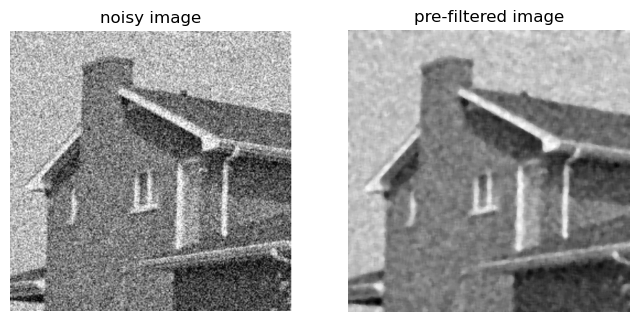

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(noisy_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('noisy image')

axs[1].imshow(image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('pre-filtered image')

plt.show()

100%|██████████| 4/4 [01:29<00:00, 22.45s/it]


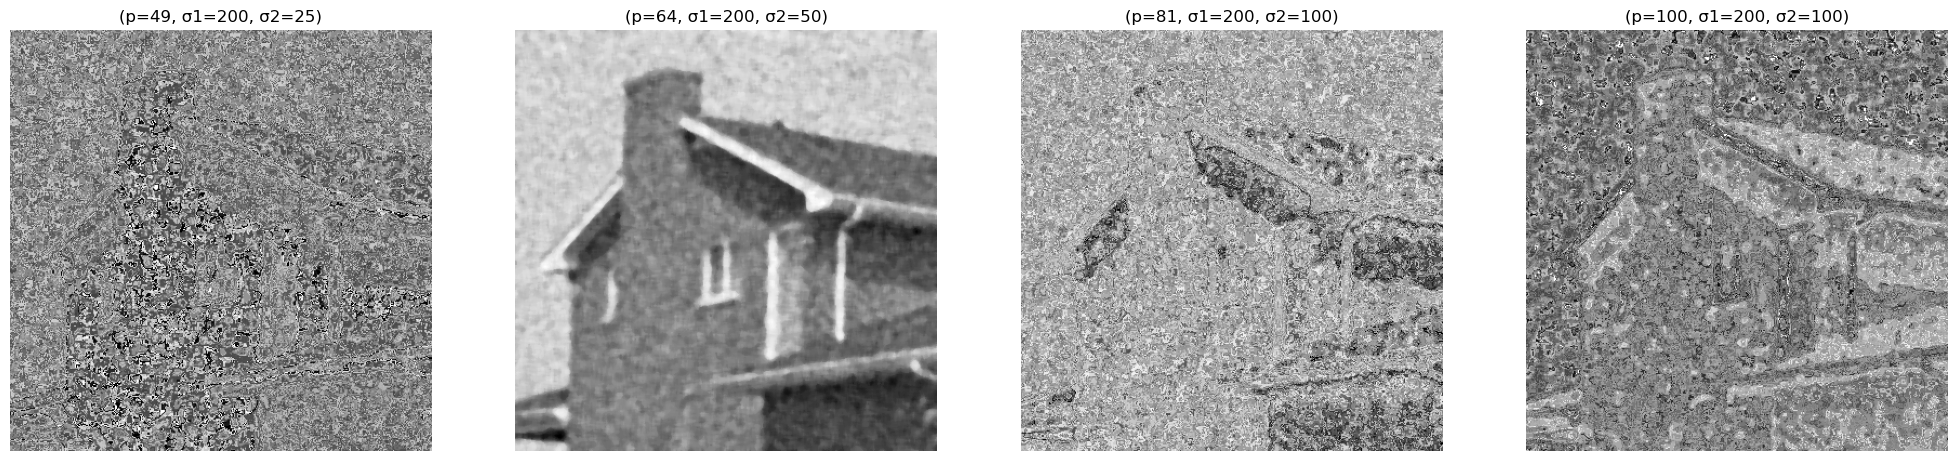

In [58]:
# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(49,200,25),(64,200,50),(81,200,100),(100,200,100),]
               
results = []

fig, axs = plt.subplots(1, 4, figsize=(25, 25))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=N_Similarity)]
    axs[i].imshow(results[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()

100%|██████████| 4/4 [01:40<00:00, 25.21s/it]


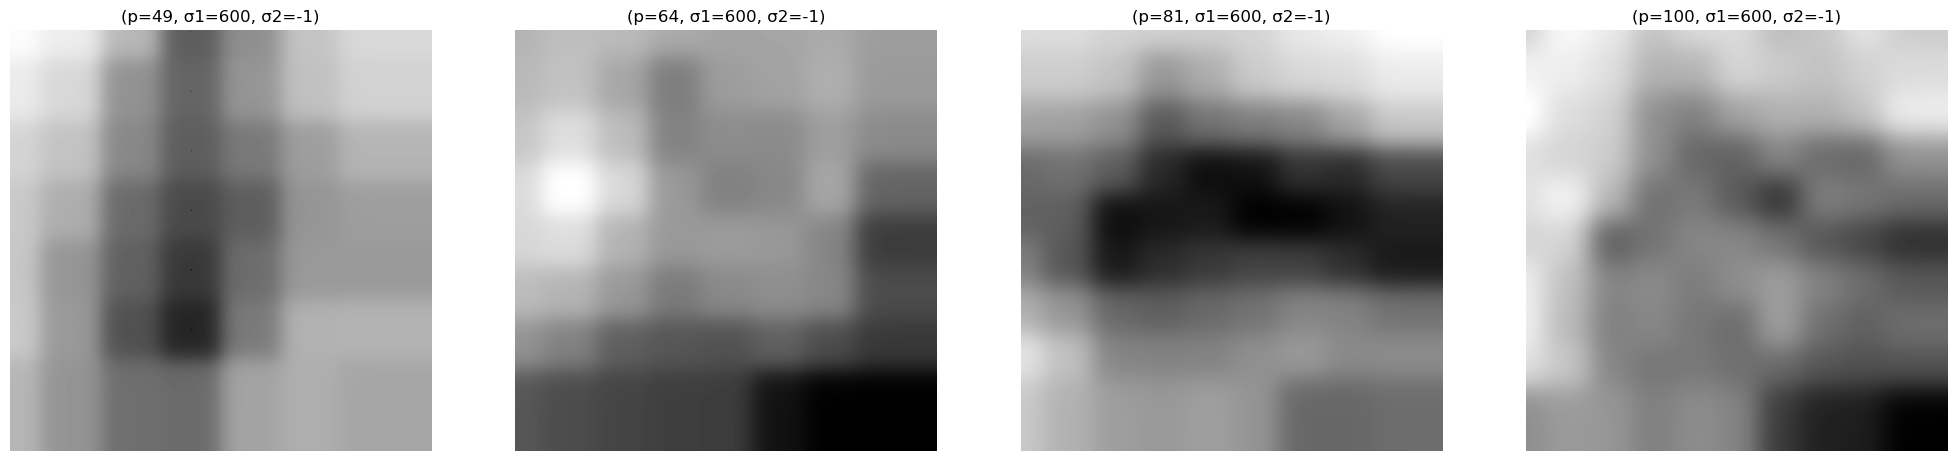

In [27]:
# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(49,600,-1),(64,600,-1),(81,600,-1),(100,600,-1),]
               
results = []

fig, axs = plt.subplots(1, 4, figsize=(25, 25))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=G_Similarity)]
    axs[i].imshow(results[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()

100%|██████████| 4/4 [13:10<00:00, 197.53s/it]


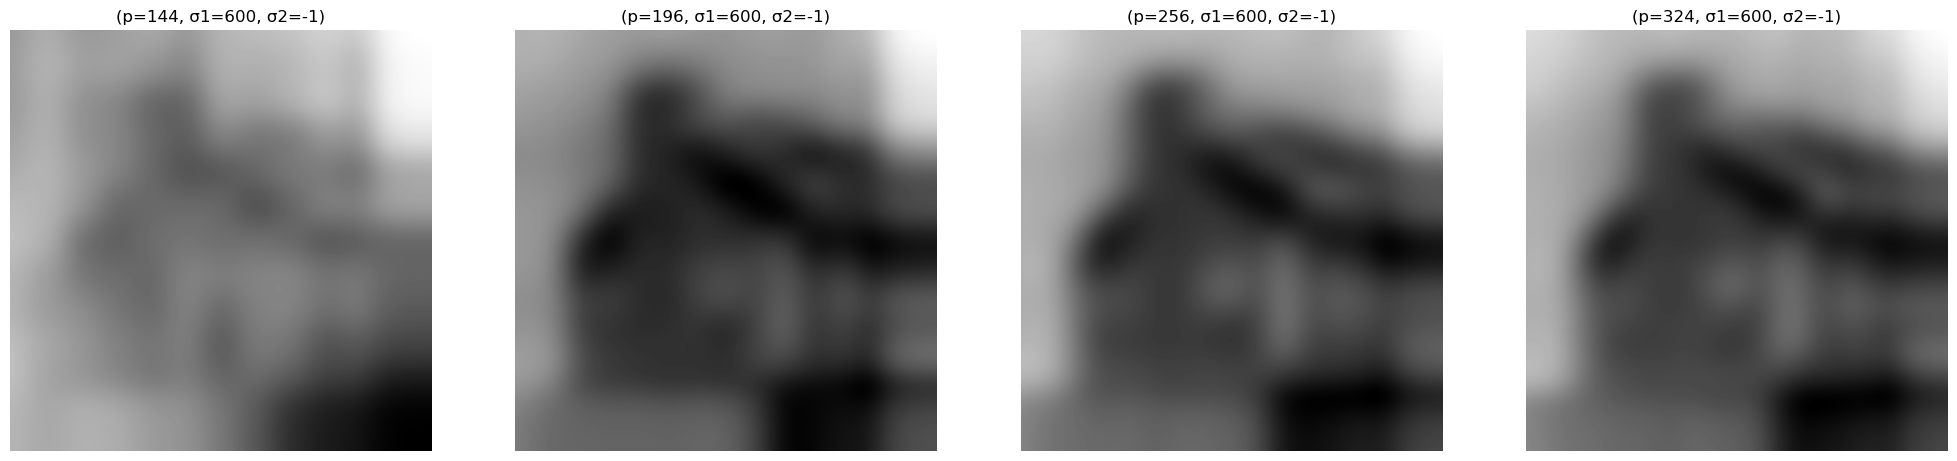

In [59]:
# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(12*12,600,-1),(14*14,600,-1),(16*16,600,-1),(18*18,600,-1),]
               
results = []

fig, axs = plt.subplots(1, 4, figsize=(25, 25))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=G_Similarity)]
    axs[i].imshow(results[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()

100%|██████████| 2/2 [27:07<00:00, 813.64s/it]


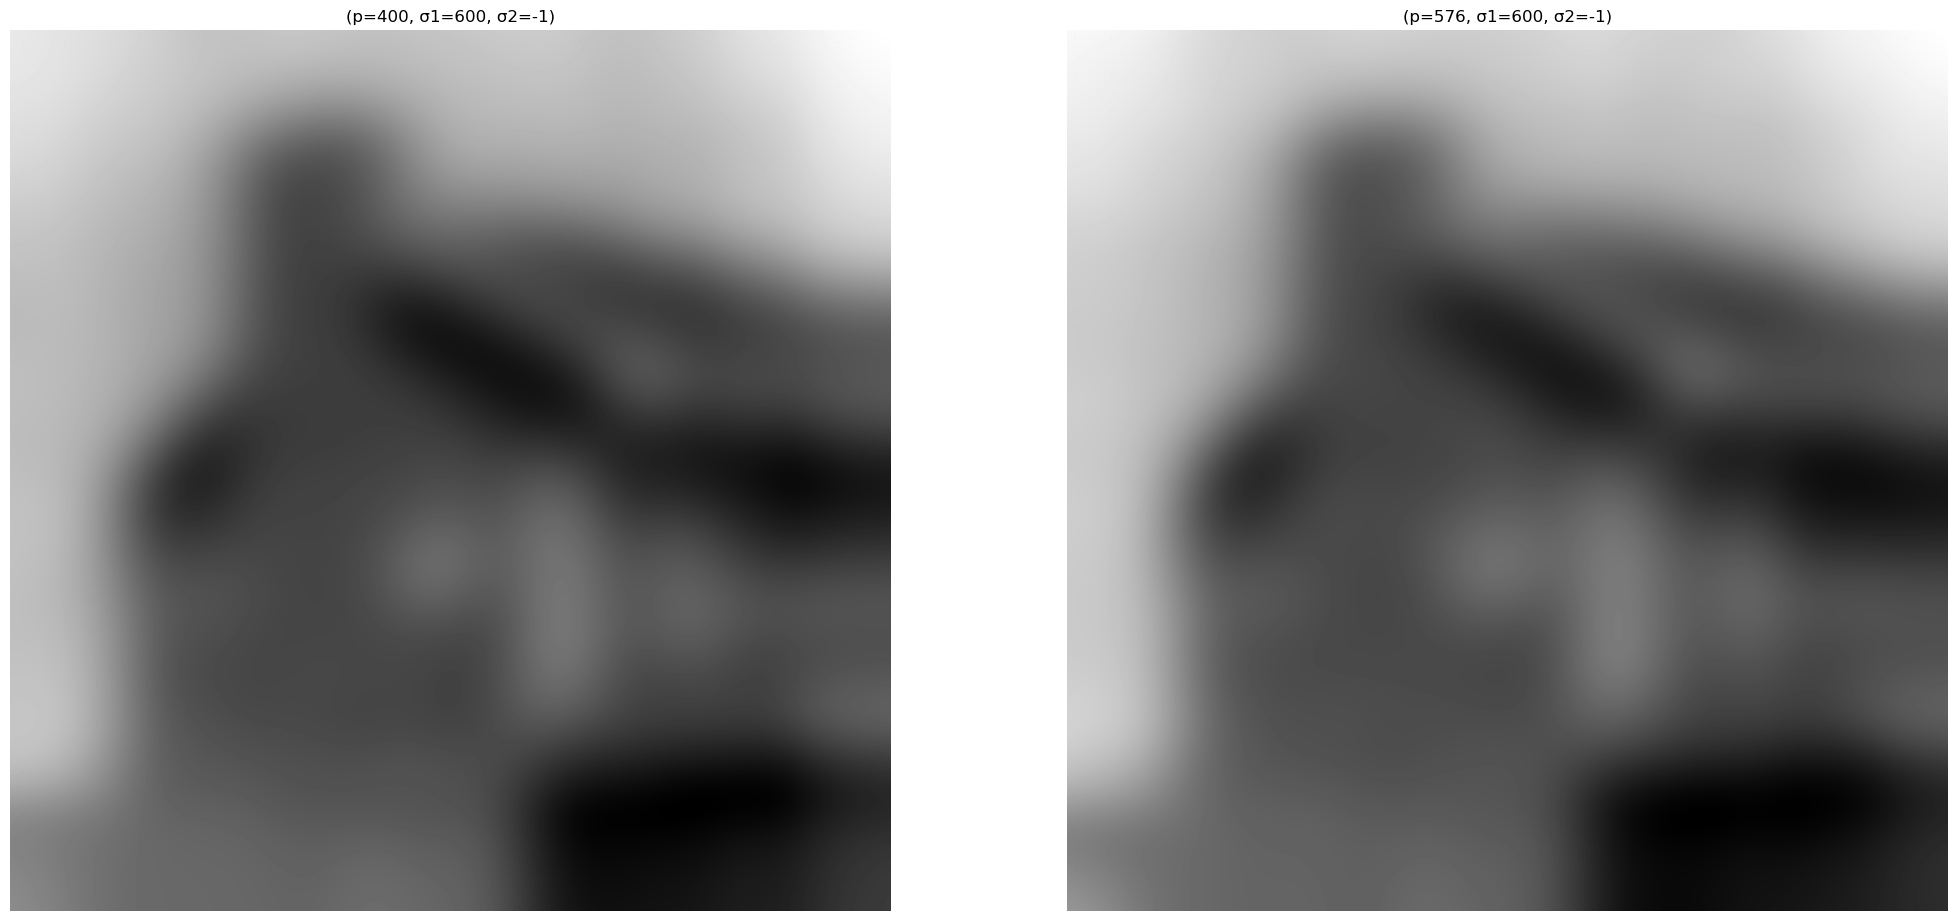

In [61]:
# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(20*20,600,-1),(24*24,600,-1),]
               
results = []

fig, axs = plt.subplots(1, 2, figsize=(25, 25))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=G_Similarity)]
    axs[i].imshow(results[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()

100%|██████████| 4/4 [05:21<00:00, 80.35s/it] 


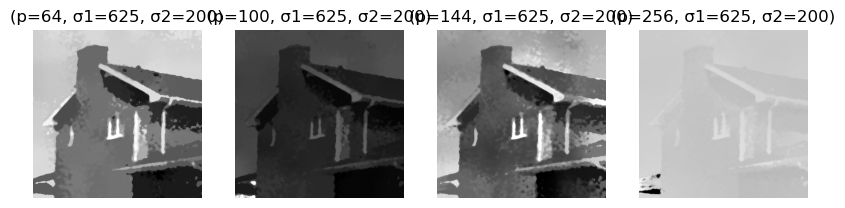

In [38]:
# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(64,625,200),(100,625,200),(144,625,200),(256,625,200),]
               
results = []

fig, axs = plt.subplots(1, 4, figsize=(10, 10))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=B_Similarity)]
    axs[i].imshow(results[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()

100%|██████████| 4/4 [01:32<00:00, 23.03s/it]


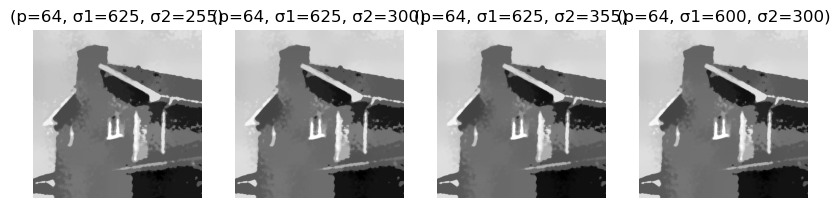

In [40]:
# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(64,625,255),(64,625,300),(64,625,355),(64,600,300)]
               
results = []

fig, axs = plt.subplots(1, 4, figsize=(10, 10))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=B_Similarity)]
    axs[i].imshow(results[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()

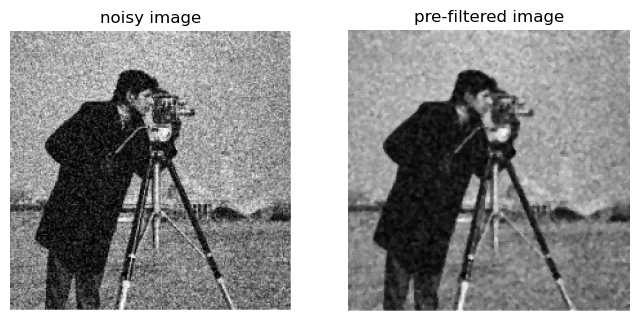

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16960\2936925034.py:45: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  sample_indices = grid_of(np.fromiter(range(y_start,y_start+num_samples*stride,stride), dtype=np.dtype((int, 1))),
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16960\2936925034.py:46: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  np.fromiter(range(x_start,x_start+num_samples*stride,stride), dtype=np.dtype((int, 1))),
100%|██████████| 1/1 [01:33<00:00, 93.46s/it]


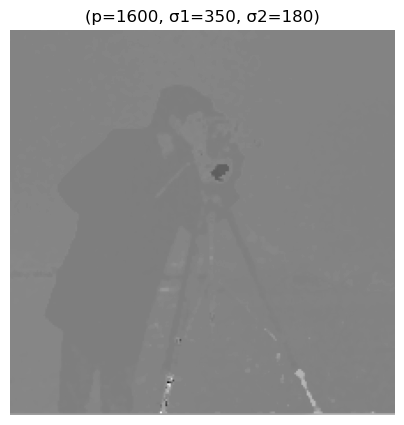

In [5]:
img_addr = 'C:\\Users\\Koorosh\\Desktop\\input_2.PNG'
noisy_image = np.array(Image.open(img_addr).convert('L'))
# print(noisy_image.shape)
image = pre_filter(noisy_image[:218,:218], kernel_size=3)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(noisy_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('noisy image')

axs[1].imshow(image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('pre-filtered image')

plt.show()



# all_results += [(experiments,results)]
# tuples = (p,σ1,σ2)
experiments = [(40*40,350,180),]
            
results = []

n = 1
fig, axs = plt.subplots(1, n, figsize=(5, 5))
for i in tqdm(range(len(experiments))):
    _exp = experiments[i]
    results += [perform_experiment(image,_exp[0],_exp[1],_exp[2], similarity=B_Similarity)]
    axs.imshow(results[i], cmap='gray')
    axs.axis('off')
    axs.set_title(f'(p={_exp[0]}, σ1={_exp[1]}, σ2={_exp[2]})')

plt.show()


In [2]:
import numpy as np
from scipy.linalg import sqrtm
from PIL import Image
import matplotlib.pyplot as plt
import cv2, itertools, copy
from tqdm import tqdm
import torch as th
_EPSILON = 1e-9


# will get input image and apply median filter on it to 
# do the pre-filtering step (in order to decouplate W and y)
def pre_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

# will get input image and p and outputs spatially uniform sample 
# and list of image's pixels after discarding samples
def spatial_uniform_sampling(image, p, x_offset=0, y_offset=0):
    # Get the dimensions of the input image
    height, width = image.shape
    
    # Compute the number of samples to take in each dimension
    num_samples = int(np.sqrt(p))
    
    # Compute the stride length for sampling in each dimension
    stride = int(np.floor(height / num_samples))
    
    # Compute the starting coordinates for sampling in each dimension
    y_start = int(np.floor((height - stride * num_samples) / 2))+y_offset
    x_start = int(np.floor((width - stride * num_samples) / 2))+x_offset

    # Compute discarded image size
    complement = np.copy(image).astype(np.int16)
    
    # Create an empty array to hold the sample sub-image
    sample = np.zeros((num_samples* num_samples))
    # _sample = np.zeros((num_samples* num_samples))

    # store indices
    # sample_indices = []
    
    # Loop over the sample sub-image and fill it with the corresponding pixels from the input image
    # x = np.fromiter(range(x_start,x_start+num_samples*stride,stride), dtype=np.dtype((int, 1)))
    # y = np.fromiter(range(y_start,y_start+num_samples*stride,stride), dtype=np.dtype((int, 1)))
    sample_indices = grid_of(np.fromiter(range(y_start,y_start+num_samples*stride,stride), dtype=np.dtype((int, 1))),
                             np.fromiter(range(x_start,x_start+num_samples*stride,stride), dtype=np.dtype((int, 1))),
                             pair_shape=(2)).reshape(-1,2)
    sample[:] = image[sample_indices[:,0],sample_indices[:,1]]
    complement[sample_indices[:,0],sample_indices[:,1]] = -1
    # for i in range(num_samples):
    #     for j in range(num_samples):
    #         y = y_start + i * stride
    #         x = x_start + j * stride
    #         sample[i, j] = image[y, x]
    #         sample_indices += [[y,x]]
    #         complement[y, x]= -1
    
    return sample.reshape((num_samples,num_samples)), np.array(sample_indices), complement[complement >= 0].astype(np.uint8),np.argwhere(complement >= 0)


def uniform_sampling(image, p):
    height, width = image.shape
    indices = np.random.choice(height*width, size=p, replace=False)

    # Convert the 1D indices to 2D coordinates
    y, x = np.unravel_index(indices, (height, width))

    # Extract the corresponding points from the image
    samples = image[y, x]
    samples_ind = np.hstack((y.reshape(-1,1),x.reshape(-1,1)))

    complement = np.copy(image).astype(np.int16)
    complement[samples_ind[:,0],samples_ind[:,1]] = -1

    complement_ind = np.argwhere(complement != -1)
    complement = complement[complement != -1]

    return samples, samples_ind, complement.astype(np.uint8), complement_ind

# will get two array and returns the grid of them
def grid_of(X1, X2, pair_shape):
    I1 = X1.reshape((-1,1)) if len(X1.shape)==1 else X1
    I2 = X2.reshape((-1,1)) if len(X2.shape)==1 else X2
    # classic itertools! slow
    # x1 =  np.fromiter(itertools.product(I1, I2), dtype=np.dtype((int, pair_shape))).reshape(I1.shape[0],I2.shape[0],-1)
    # njit powered! 5x faster
    x = cartesian_jit((np.arange(I1.shape[0], dtype=np.int64), np.arange(I2.shape[0], dtype=np.int64))).astype(np.uint64)
    x2 =  np.hstack((I1[x[:,0]],I2[x[:,1]])).reshape(I1.shape[0], I2.shape[0], -1)
    return x2

# Classical Gaussian similarity measure between the pixel
# x1,x2 are two vectors
def Exponential_Kernel(x, σ=2500):
    delta = np.einsum('ijkl,k->ijl',x.reshape(x.shape[0],x.shape[1],2,-1),np.array([-1,1]))
    n_sqr = np.einsum('ijk,ijk->ij',delta, delta)
    f_rsl = np.exp(-n_sqr/σ)
    return f_rsl

# 0,1 Linear Kernel
def Linear_kernel(x, σ=255):
    delta = np.einsum('ijkl,k->ijl',x.reshape(x.shape[0],x.shape[1],2,-1),np.array([-1,1]))
    f_rsl = 1.-np.abs(delta/σ)
    return f_rsl

# Guassian Kernel Similarity Measure
def G_Similarity(X1, X2=None, σ1=2500):
    X2 = X1 if X2 is None else X2
    return Exponential_Kernel(grid_of(X1,X2,pair_shape=(2,2)), σ=σ1)

# Bilateral Kernal Similarity measure
def B_Similarity(X1,Y1,X2=None,Y2=None, σ1=2500, σ2=500):
    X2 = X1 if X2 is None else X2
    Y2 = Y1 if Y2 is None else Y2
    spatial = Exponential_Kernel(grid_of(X1,X2,pair_shape=(2,2)), σ=σ1)
    intensity = Exponential_Kernel(grid_of(Y1,Y2,pair_shape=(2)), σ=σ2)
    return spatial*intensity

# 0,1 intensity similarity
def N_Similarity(Y1, Y2=None, σ1=255, is_linear=True):
    Y2 = Y1 if Y2 is None else Y2
    if is_linear: intensity = Linear_kernel(grid_of(Y1,Y2,pair_shape=(2)), σ=σ1)
    else : intensity = Exponential_Kernel(grid_of(Y1,Y2,pair_shape=(2)), σ=σ1)
    return intensity.squeeze(-1)


# compute global filter given the image, number of spatial uniform
# samples and number of leading eigen vectors
def Spectral_Approximation_of_the_Filter_W(image, _iter, p, x_offset, y_offset, similarity_measure, σ1=2500, σ2=500, is_linear=True):

    # specify given image
    # image = np.random.randint(0,10,size=(10,10))

    # Specify the iteration parameter
    # _iter = 4

    # Load the input image
    # image = np.random.randint(1,40,size=(n,n))

    # Specify the size of the sample sub-image
    # p = 25
    n = image.shape[0] * image.shape[1]

    # Get the sample sub-image using spatially uniform sampling
    # sample, sample_ind, complement, complement_ind = spatial_uniform_sampling(image, p, x_offset, y_offset)
    sample, sample_ind, complement, complement_ind = spatial_uniform_sampling(image, p)

    # list of sampled pixels
    sample = sample.reshape(-1)

    if similarity_measure.__name__=='G_Similarity':
        # similarity sub kernel
        K_A = similarity_measure(sample_ind, σ1=σ1)

        # similarity rectangular sub kernel
        K_AB = similarity_measure(sample_ind, complement_ind, σ1=σ1)

    elif similarity_measure.__name__=='B_Similarity':
        # similarity sub kernel
        K_A = similarity_measure(sample_ind, sample, σ1=σ1, σ2=σ2)

        # similarity rectangular sub kernel
        K_AB = similarity_measure(sample_ind, sample, complement_ind, complement, σ1=σ1, σ2=σ2)
    
    elif similarity_measure.__name__=='N_Similarity':
        # similarity sub kernel
        K_A = similarity_measure(sample, σ1=σ1, is_linear=is_linear)

        # similarity rectangular sub kernel
        K_AB = similarity_measure(sample, complement, σ1=σ1, is_linear=is_linear)

    # Nystrom Approximation
    # 1-
    π_A, Φ_A, = np.linalg.eig(K_A)
    # 2-
    Φ_A_Π_A = np.einsum('ij,j->ij',Φ_A,1./(π_A+_EPSILON))
    Φ_tilde = np.vstack((Φ_A,K_AB.T@Φ_A_Π_A))#Φ_A@np.diag(1./(π_A+_EPSILON))))

    # Sinkhorn
    # 3-
    r,π_A = np.ones((n,1)),π_A.reshape(-1,1)
    # 4-
    for _ in range(_iter):
        c = 1/(Φ_tilde@(π_A*(Φ_tilde.T@r)))
        r = 1/(Φ_tilde@(π_A*(Φ_tilde.T@c)))
    # 5-
    # W_A_AB = np.zeros((p,n))
    tiled_c = (np.tile(c, [1,p])*Φ_tilde).T
    Φ_tilde_p_n = Φ_tilde[:p,:]
    tiled_π_A = np.tile(π_A.T, [p,1])
    _W_A_AB = (tiled_π_A*Φ_tilde_p_n)@tiled_c
    W_A_AB = np.einsum('i,ij->ij',(r.reshape(-1))[:p],_W_A_AB)
    # for i in range(0,p):
    #     W_A_AB[i,:] = r[i]*(π_A.T*Φ_tilde[i,:])@tiled_c
    # W_A_AB = np.squeeze(W_A_AB, axis=1)
    # 6-
    W_A = W_A_AB[:,0:p]
    # 7-
    W_AB = W_A_AB[:,p:n]

    # Orthogonalization
    # 8-
    W_A_sqrt = sqrtm(W_A)
    # 9-
    W_A_sqrt_inv = np.linalg.inv(W_A_sqrt)
    Q = W_A + W_A_sqrt_inv@W_AB@W_AB.T@W_A_sqrt_inv
    # 10-
    s_Q, V_Q, = np.linalg.eig(Q)
    # 11-
    V_Q_S_Q = np.einsum('ij,j->ij',V_Q,1./np.sqrt(s_Q))
    V_tilde = np.vstack((W_A,W_AB.T))@np.linalg.inv(W_A_sqrt)@V_Q_S_Q#V_Q@np.diag(1./np.sqrt(s_Q))
    # 12-
    s_tilde = s_Q

    return (V_tilde, s_tilde, np.vstack((sample.reshape(-1,1),complement.reshape(-1,1))), sample_ind, complement_ind, sample, complement)

# perform experiment given parameters
def perform_experiment(image, p, σ1, σ2, similarity=B_Similarity):
    V,s,y,s_ind,c_ind,_, _ = Spectral_Approximation_of_the_Filter_W(image, _iter=4, p=p, x_offset=10, y_offset=10, similarity_measure=similarity, σ1=σ1, σ2=σ2)
    # W_approx = V@np.diag(s)
    W_approx = np.einsum('ij,j->ij',V,s)
    z_hat = (W_approx@(V.T@y)).real
    f_result = np.zeros_like(z_hat).reshape(image.shape)
    f_result[s_ind[:,0],s_ind[:,1]]=z_hat[0:p,0]
    f_result[c_ind[:,0],c_ind[:,1]]=z_hat[p:,0]
    return f_result
    

#### Experiments

##### make cartesian 5x faster with jit 

In [3]:
from numba import njit

@njit(cache=True)
def cartesian_jit(arrays):

    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list or tuple of arrays
        1-D arrays to form the cartesian product of.


    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    n = 1
    for x in arrays:
        n *= x.size
    out = np.zeros((n, len(arrays)))


    for i in range(len(arrays)):
        m = int(n / arrays[i].size)
        out[:n, i] = np.repeat(arrays[i], m)
        n //= arrays[i].size

    n = arrays[-1].size
    for k in range(len(arrays)-2, -1, -1):
        n *= arrays[k].size
        m = int(n / arrays[k].size)
        for j in range(1, arrays[k].size):
            out[j*m:(j+1)*m,k+1:] = out[0:m,k+1:]
    return out

In [42]:

I1 = np.random.randint(0,100,(64,2))
I2 = np.random.randint(0,100,(64,2))

x = cartesian_jit((np.arange(I1.shape[0]), np.arange(I2.shape[0]))).astype(np.uint8)

p = np.hstack((I1[x[:,0]],I2[x[:,1]])).reshape(I1.shape[0], I2.shape[0], -1)

k = grid_of(I1,I2,pair_shape=(2,2))

print(p.shape)
print(k.shape)






(64, 64, 4)
(64, 64, 4)


In [69]:
import numpy as np

# create a NumPy array
a = np.array([1, 2, 3, 4, 5, 6])

# create a reference to the same data with a modified shape using reshape
b = a.reshape((2, 3))

# create a reference to the same data with a modified shape using np.newaxis
c = a[:, np.newaxis]

# print the original array and the two references
print("a:", a)
print("b:", b)
print("c:", c)

a[4]=100

print("a:", a)
print("b:", b)
print("c:", c)

a: [1 2 3 4 5 6]
b: [[1 2 3]
 [4 5 6]]
c: [[1]
 [2]
 [3]
 [4]
 [5]
 [6]]
a: [  1   2   3   4 100   6]
b: [[  1   2   3]
 [  4 100   6]]
c: [[  1]
 [  2]
 [  3]
 [  4]
 [100]
 [  6]]
